<div align="center">
  <h1></h1>
  <h1>Universidad Nacional de Colombia</h1>
  <h2>Procesamiento del lenguaje natural</h2>
  <h2>Proyecto</h2>
  <h2>Dr Diomedes:
  <h3>Un Bot con sentimiento</h3>
  <h3>Grupo 1</h3>
  <strong>Estudiantes:</strong>  <br>
  Jhojan Sebastian Arango Castillo (<a href="mailto:jsarangoca@unal.edu.co">jsarangoca@unal.edu.co</a>) <br>
  Diego Andres Benitez Duarte (<a href="mailto:dabenitezd@unal.edu.co">dabenitezd@unal.edu.co</a>) <br>
  Jeraldine Muñoz Alvarado (<a href="mailto:jemunozal@unal.edu.co">jemunozal@unal.edu.co</a>) <br>
  Johan Sebastian Suarez Sepulveda (<a href="mailto:jemunozal@unal.edu.co">jssuarezse@unal.edu.co</a>) <br>
  <strong>Profesora:</strong> Elizabeth León Guzmán
</div>

# Carga de los datos

En esta primera fase, importamos las bibliotecas esenciales para el análisis de datos: Pandas para la manipulación de los datos y Numpy para operaciones numéricas. Cargamos el conjunto de datos desde un archivo Excel en un DataFrame de Pandas, lo ordenamos por nombre de canción para asegurar consistencia y mostramos las primeras filas para verificar que la carga se haya realizado correctamente. Finalmente, revisamos las dimensiones del DataFrame y el número de canciones únicas para tener una idea general del volumen de datos con el que trabajaremos.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df2 = pd.read_excel("/content/letras_etiquetadas_pivot.xlsx")

In [ ]:
df2.head(5)

,nombre_cancion,linea,etiqueta
0,26 de mayo,el veintiséis del mes de mayo,otros
1,A mi papá,voy a componé un merengue,otros
2,A un cariño del alma,cuando se acaban todas las palabras,otros
3,A un colega,de una manera especial y en una forma correcta,otros
4,A Un Ladito Del Camino,hoy me siento enamorado,amor


In [ ]:
df = df2.sort_values(by='nombre_cancion').reset_index(drop=True)
display(df.head())

,nombre_cancion,linea,etiqueta
0,26 de mayo,el veintiséis del mes de mayo,otros
1,26 de mayo,"que renovaran su edad,",otros
2,26 de mayo,y hoy se conoce con el nombre de diomedes.,otros
3,26 de mayo,y se volvieran a enamorar,amor
4,26 de mayo,y al poco tiempo naciera yo nuevamente.,vida


In [ ]:
df['nombre_cancion'].nunique(), df.shape

(420, (17121, 3))

# Preprocesamiento del texto

Antes de que un modelo pueda entender el texto, es fundamental limpiarlo y estandarizarlo. Este proceso, conocido como preprocesamiento, elimina el ruido que podría confundir al algoritmo. En esta sección, definimos una función `limpiar_texto` que realiza las siguientes tareas:

- **Convertir a minúsculas:** Unifica el texto para que palabras como "Amor" y "amor" sean tratadas como iguales.

- **Eliminar signos de puntuación y números:** Se remueven caracteres que no aportan significado semántico.

- **Quitar stopwords:** Se eliminan palabras muy comunes en español (como "el", "de", "y", "que") que no suelen aportar información relevante sobre el sentimiento o tema del texto. Hemos personalizado la lista de stopwords para conservar algunas palabras con carga afectiva como "nunca" o "siempre".

- **Normalizar espacios en blanco:** Se eliminan espacios extra para tener un formato consistente.

Aplicamos esta función a cada línea de las letras de las canciones, creando una nueva columna `linea_limpia` que contendrá el texto listo para ser procesado.

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import nltk

# Descargar stopwords en español (solo la primera vez)
nltk.download('stopwords')

# Creamos una lista de stopwords base en español
stop_words = set(stopwords.words('spanish'))

# Opcional: eliminar algunas palabras que sí tienen valor afectivo
palabras_relevantes = {'más', 'menos', 'nunca', 'siempre', 'nadie', 'nada'}
stop_words = stop_words - palabras_relevantes

def limpiar_texto(texto):
    texto = texto.lower()                                 # minúsculas
    texto = re.sub(f"[{string.punctuation}]", "", texto)  # quitar signos
    texto = re.sub(r"\d+", "", texto)                     # quitar números
    texto = re.sub(r"\s+", " ", texto).strip()            # espacios múltiples
    palabras = [p for p in texto.split() if p not in stop_words]
    texto = " ".join(palabras)
    return texto

df['linea_limpia'] = df['linea'].apply(limpiar_texto)
display(df[['linea', 'linea_limpia']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,linea,linea_limpia
0,el veintiséis del mes de mayo,veintiséis mes mayo
1,"que renovaran su edad,",renovaran edad
2,y hoy se conoce con el nombre de diomedes.,hoy conoce nombre diomedes
3,y se volvieran a enamorar,volvieran enamorar
4,y al poco tiempo naciera yo nuevamente.,tiempo naciera nuevamente


# Vectorización TF-IDF

Los modelos de machine learning no trabajan directamente con texto, sino con números. Por lo tanto, necesitamos convertir nuestras líneas de texto limpias en vectores numéricos. Para ello, utilizamos la técnica **TF-IDF (Term Frequency-Inverse Document Frequency)**.

TF-IDF es una medida estadística que evalúa la importancia de una palabra en un documento (en nuestro caso, una línea de la canción) en relación con el corpus completo (todas las líneas). Su fórmula es:

$$TF−IDF=TF×IDF$$

donde:

- **TF (Frecuencia del Término):** Mide la frecuencia con la que aparece una palabra en un documento.

- **IDF (Frecuencia Inversa del Documento):** Reduce el peso de las palabras que son muy comunes en todos los documentos.

De esta manera, las palabras que son frecuentes en una línea pero raras en el resto del corpus reciben un peso mayor, lo que ayuda al modelo a identificar términos clave para cada categoría. Aquí configuramos el vectorizador para que considere palabras individuales y pares de palabras consecutivas (`ngram_range=(1,2)`), lo que le permite capturar un poco más de contexto.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2
)

X = vectorizer.fit_transform(df['linea_limpia'])
y = df['etiqueta']

print("Shape del vector TF-IDF:", X.shape)

Shape del vector TF-IDF: (17121, 11332)


# Entrenamiento

Esta es la sección principal donde construiremos y evaluaremos diferentes modelos de clasificación. El primer paso es dividir nuestro conjunto de datos vectorizados en dos subconjuntos:

- **Conjunto de entrenamiento** (`X_train`, `y_train`): Se utiliza para que el modelo aprenda los patrones en los datos.

- **Conjunto de prueba **(`X_test`, `y_test`): Se utiliza para evaluar el rendimiento del modelo en datos que no ha visto antes.

Usamos una división estratificada (`stratify=y`) para asegurar que la proporción de cada etiqueta (sentimiento) sea la misma tanto en el conjunto de entrenamiento como en el de prueba, evitando así sesgos en la evaluación.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Regresión Logística con "Otros"

Como primer experimento, entrenamos un modelo de Regresión Logística utilizando todas las categorías, incluida la etiqueta "otros". La Regresión Logística es un algoritmo rápido y muy interpretable que sirve como un excelente punto de partida o modelo base para entender el rendimiento inicial en nuestro problema de clasificación.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     amistad       1.00      0.48      0.65        21
        amor       1.00      0.83      0.91       374
    consejos       0.00      0.00      0.00         3
  costumbres       0.00      0.00      0.00         4
   despedida       1.00      0.19      0.32        26
     familia       1.00      0.42      0.59        77
      fiesta       0.86      0.25      0.39        24
    infancia       0.00      0.00      0.00        12
      música       1.00      0.60      0.75        75
  naturaleza       0.95      0.58      0.72       216
   nostalgia       0.92      0.45      0.60        49
       otros       0.81      1.00      0.89      1928
 reflexiones       0.87      0.48      0.62        27
    religión       0.89      0.65      0.75       187
      tierra       0.96      0.49      0.65        47
     trabajo       1.00      0.22      0.36         9
    tristeza       0.94      0.76      0.84       105
        vida       0.91    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Lo mismo pero eliminando "Otros"

La categoría "otros" suele ser muy heterogénea y puede contener muchas subcategorías internas que se escaparon de una clasificación más detallada, lo que podría dificultar que el modelo aprenda a distinguir las clases más definidas. En esta sección, filtramos el DataFrame para excluir todas las líneas etiquetadas como "otros". Luego, repetimos el proceso de vectorización y división de datos con este nuevo conjunto de datos más enfocado. A partir de aquí, todos los modelos se entrenarán con este dataset filtrado para intentar mejorar la precisión en la clasificación de las categorías de interés.

In [ ]:
df_filtrada = df[df['etiqueta'] != 'otros']
df_filtrada['linea_limpia'] = df_filtrada['linea'].apply(limpiar_texto)
X = vectorizer.fit_transform(df_filtrada['linea_limpia'])
y = df_filtrada['etiqueta']

/tmp/ipython-input-739212210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrada['linea_limpia'] = df_filtrada['linea'].apply(limpiar_texto)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### (1) Regresión Logística

Volvemos a entrenar el modelo de Regresión Logística, pero esta vez con el conjunto de datos filtrado (sin la categoría "otros"). Este será nuestro nuevo modelo base, y su rendimiento nos servirá como referencia para compararlo con los algoritmos más complejos que probaremos a continuación. Además, visualizamos su desempeño a través de una matriz de confusión, una herramienta gráfica que nos permite ver en qué clases acierta el modelo y en cuáles se confunde.

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     amistad       1.00      0.81      0.89        21
        amor       0.90      0.95      0.93       374
    consejos       0.00      0.00      0.00         3
  costumbres       1.00      0.50      0.67         4
   despedida       0.95      0.69      0.80        26
     familia       0.99      0.90      0.94        77
      fiesta       0.92      0.50      0.65        24
    infancia       1.00      0.42      0.59        12
      música       1.00      0.87      0.93        75
  naturaleza       0.78      0.88      0.83       216
   nostalgia       0.95      0.78      0.85        49
 reflexiones       0.95      0.78      0.86        27
    religión       0.89      0.90      0.90       187
      tierra       0.98      0.87      0.92        47
     trabajo       1.00      0.33      0.50         9
    tristeza       0.92      0.95      0.93       105
        vida       0.90      0.98      0.94       241

    accuracy              

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


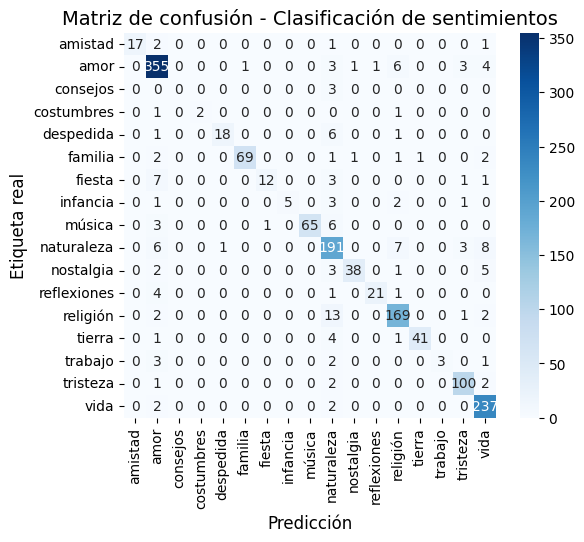

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,        # muestra los números
    fmt='d',           # formato entero
    cmap='Blues',      # color azul
    xticklabels=clf.classes_,  # etiquetas eje X
    yticklabels=clf.classes_   # etiquetas eje Y
)

plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.title('Matriz de confusión - Clasificación de sentimientos', fontsize=14)
plt.show()


### (2) SVM

A continuación, probamos un clasificador de Máquinas de Vectores de Soporte (SVM), específicamente `LinearSVC`. Los modelos SVM son muy efectivos en espacios de alta dimensionalidad, como es el caso de los datos de texto vectorizados con TF-IDF. El objetivo de un SVM es encontrar el hiperplano que mejor separa las clases en el espacio de características. Usamos `class_weight='balanced'` para que el modelo preste más atención a las clases con menos ejemplos, lo cual es útil si nuestro dataset está desbalanceado.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm_clf = LinearSVC(class_weight='balanced')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("=== Linear SVM ===")
print(classification_report(y_test, y_pred_svm))

=== Linear SVM ===
              precision    recall  f1-score   support

     amistad       0.95      1.00      0.98        21
        amor       1.00      0.94      0.97       374
    consejos       1.00      1.00      1.00         3
  costumbres       0.80      1.00      0.89         4
   despedida       0.93      0.96      0.94        26
     familia       0.95      0.96      0.95        77
      fiesta       0.85      0.96      0.90        24
    infancia       0.80      1.00      0.89        12
      música       0.97      0.92      0.95        75
  naturaleza       0.90      0.91      0.91       216
   nostalgia       0.93      0.88      0.91        49
 reflexiones       0.86      0.93      0.89        27
    religión       0.95      0.94      0.94       187
      tierra       0.98      0.94      0.96        47
     trabajo       0.80      0.89      0.84         9
    tristeza       0.93      0.99      0.96       105
        vida       0.94      0.97      0.95       241

    acc

### (3) Naive-Bayes Multinomial

Aquí implementamos un clasificador Naive Bayes Multinomial. Este es un algoritmo probabilístico basado en el teorema de Bayes que es conocido por su eficiencia y buen rendimiento en tareas de clasificación de texto. A pesar de su "ingenuidad" (asume que las características son independientes entre sí), a menudo funciona sorprendentemente bien para categorizar documentos.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)

print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))

=== Naive Bayes ===
              precision    recall  f1-score   support

     amistad       1.00      0.24      0.38        21
        amor       0.55      0.98      0.71       374
    consejos       0.00      0.00      0.00         3
  costumbres       0.00      0.00      0.00         4
   despedida       0.00      0.00      0.00        26
     familia       1.00      0.69      0.82        77
      fiesta       0.00      0.00      0.00        24
    infancia       0.00      0.00      0.00        12
      música       1.00      0.47      0.64        75
  naturaleza       0.85      0.81      0.83       216
   nostalgia       1.00      0.41      0.58        49
 reflexiones       0.00      0.00      0.00        27
    religión       0.93      0.76      0.84       187
      tierra       0.95      0.40      0.57        47
     trabajo       1.00      0.22      0.36         9
    tristeza       0.94      0.64      0.76       105
        vida       0.83      0.92      0.87       241

    ac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### (4) RF

Este algoritmo construye múltiples árboles de decisión durante el entrenamiento y combina sus predicciones (mediante un voto mayoritario) para obtener una clasificación final más precisa y robusta. Los bosques aleatorios son excelentes para reducir el sobreajuste (overfitting) y capturar interacciones complejas entre las características.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
              precision    recall  f1-score   support

     amistad       0.91      1.00      0.95        21
        amor       0.99      0.91      0.95       374
    consejos       1.00      1.00      1.00         3
  costumbres       0.80      1.00      0.89         4
   despedida       0.79      0.88      0.84        26
     familia       0.96      0.94      0.95        77
      fiesta       0.85      0.92      0.88        24
    infancia       0.33      0.92      0.49        12
      música       0.97      0.89      0.93        75
  naturaleza       0.93      0.83      0.88       216
   nostalgia       0.91      0.86      0.88        49
 reflexiones       0.86      0.93      0.89        27
    religión       0.89      0.92      0.90       187
      tierra       0.98      0.94      0.96        47
     trabajo       0.64      0.78      0.70         9
    tristeza       0.89      0.97      0.93       105
        vida       0.91      0.96      0.94       241

    

### Resumen

Para tener una visión clara del rendimiento comparativo, en esta sección agrupamos los cuatro modelos clásicos entrenados (Regresión Logística, SVM, Naive Bayes y Random Forest). Calculamos la métrica F1-Score (macro) para cada uno. El F1-Score es una media armónica entre la precisión y la exhaustividad (recall), y el promedio "macro" lo calcula para cada clase y luego promedia los resultados, tratando a todas las clases por igual. Esto nos permite determinar de manera justa cuál de los modelos clásicos funciona mejor para nuestro problema.

In [ ]:
from sklearn.metrics import f1_score

modelos = {
    "LogisticRegression": clf,
    "LinearSVM": svm_clf,
    "NaiveBayes": nb_clf,
    "RandomForest": rf_clf,
    #"GradientBoosting": gb_clf
}

for nombre, modelo in modelos.items():
    preds = modelo.predict(X_test if nombre in ['LinearSVM','LogisticRegression','NaiveBayes'] else X_test.toarray())
    f1 = f1_score(y_test, preds, average='macro')
    print(f"{nombre}: F1-macro = {f1:.3f}")

LogisticRegression: F1-macro = 0.772
LinearSVM: F1-macro = 0.931
NaiveBayes: F1-macro = 0.433
RandomForest: F1-macro = 0.880


### (5) MLP

Dando un paso hacia el deep learning, ahora implementamos un Perceptrón Multicapa (MLP). Se trata de una red neuronal artificial con varias capas densamente conectadas. A diferencia de los modelos anteriores, las redes neuronales pueden aprender representaciones y patrones mucho más complejos y no lineales en los datos. Nuestra arquitectura consta de una capa de entrada, dos capas ocultas con funciones de activación `ReLU` y una capa de salida con activación `softmax` para la clasificación multiclase. También usamos `Dropout` para regularizar el modelo y prevenir el sobreajuste.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Codificar etiquetas
enc = LabelEncoder()
y_train_enc = enc.fit_transform(y_train)
y_test_enc = enc.transform(y_test)

In [ ]:
# Crear red MLP
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(enc.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train.toarray(), y_train_enc,
                    validation_split=0.1, epochs=10, batch_size=64, verbose=1)

loss, acc = model.evaluate(X_test.toarray(), y_test_enc)
print(f"Accuracy test: {acc:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.2695 - loss: 2.4200 - val_accuracy: 0.6828 - val_loss: 1.2597
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7514 - loss: 0.9884 - val_accuracy: 0.8898 - val_loss: 0.4960
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9350 - loss: 0.3183 - val_accuracy: 0.9282 - val_loss: 0.3194
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9742 - loss: 0.1396 - val_accuracy: 0.9349 - val_loss: 0.2744
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9808 - loss: 0.0886 - val_accuracy: 0.9349 - val_loss: 0.2704
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9908 - loss: 0.0463 - val_accuracy: 0.9432 - val_loss: 0.2676
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9901 - loss: 0.0466 - val_accuracy: 0.9416 - val_loss: 0.2704
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9944 - loss: 0.0313 - val_accuracy: 0.9482 - v

In [ ]:
type(X_test), type(X_train)

(scipy.sparse._csr.csr_matrix, scipy.sparse._csr.csr_matrix)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
=== Reporte de Clasificación - MLP ===
              precision    recall  f1-score   support

     amistad       1.00      0.95      0.98        21
        amor       0.97      0.95      0.96       374
    consejos       0.00      0.00      0.00         3
  costumbres       1.00      0.75      0.86         4
   despedida       0.88      0.85      0.86        26
     familia       0.95      0.97      0.96        77
      fiesta       0.87      0.83      0.85        24
    infancia       1.00      0.92      0.96        12
      música       0.97      0.92      0.95        75
  naturaleza       0.86      0.91      0.89       216
   nostalgia       0.97      0.78      0.86        49
 reflexiones       0.90      0.70      0.79        27
    religión       0.93      0.91      0.92       187
      tierra       0.98      0.94      0.96        47
     trabajo       0.86      0.67      0.75         9
    tristeza       0.90      0.95      0.93       105
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


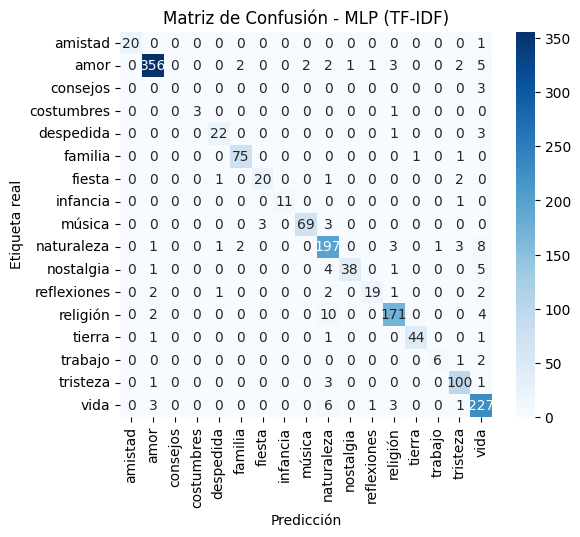

In [ ]:
# Predicciones
y_pred_probs = model.predict(X_test.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)

# Reporte de clasificación
print("=== Reporte de Clasificación - MLP ===")
print(classification_report(y_test_enc, y_pred, target_names=enc.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=enc.classes_, yticklabels=enc.classes_)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión - MLP (TF-IDF)')
plt.show()

### (6) LSTM

Finalmente, exploramos un modelo diseñado específicamente para datos secuenciales como el texto: una red LSTM (Long Short-Term Memory). A diferencia del enfoque TF-IDF que pierde el orden de las palabras, las LSTM son un tipo de Red Neuronal Recurrente (RNN) que procesa las palabras en secuencia, permitiéndole capturar el contexto y las dependencias a largo plazo en una oración. Para preparar los datos, realizamos los siguientes pasos:

- **Tokenización:** Convertimos cada palabra en un número entero único.

- **Padding:** Aseguramos que todas las secuencias de números tengan la misma longitud.

- **Embedding:** Creamos una capa que aprende una representación vectorial densa para cada palabra, capturando sus relaciones semánticas.

Este modelo es computacionalmente más costoso, pero tiene el potencial de entender el lenguaje de una manera más profunda.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Tokenización
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['linea_limpia'])

X_seq = tokenizer.texts_to_sequences(df['linea_limpia'])
X_pad = pad_sequences(X_seq, maxlen=40, padding='post')

# Codificar etiquetas
enc = LabelEncoder()
y_enc = enc.fit_transform(df['etiqueta'])

# División
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# Modelo LSTM
model = Sequential([
    Embedding(input_dim=X_train.shape[0], output_dim=100, input_length=40),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(enc.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=64, verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy test: {acc:.3f}")


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.5029 - loss: 2.0188 - val_accuracy: 0.5526 - val_loss: 1.7185
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.5626 - loss: 1.7268 - val_accuracy: 0.5526 - val_loss: 1.7146
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.5683 - loss: 1.6911 - val_accuracy: 0.5526 - val_loss: 1.7181
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.5725 - loss: 1.6828 - val_accuracy: 0.5526 - val_loss: 1.7139
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - accuracy: 0.5681 - loss: 1.6874 - val_accuracy: 0.5526 - val_loss: 1.7139
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.5612 - loss: 1.7104 - val_accuracy: 0.5526 - val_loss: 1.7143
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.5591 - loss: 1.7090 - val_accuracy: 0.5526 - val_loss: 1.7161
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.5625 - loss: 1.6847 - val